In [30]:
import xarray as xr
import numpy as np

In [31]:
dnc = "/home/rfrost/simulations/nc/full_step_9/"
t0 = 576000
t1 = 1152000
dt = 1000
height = 0.25

# z/zi value to be plotted
h = height

# read in polar autocorrelation
Rww = xr.open_dataarray(f"{dnc}R_pol_zzi{int(h*100)}.nc")

# rolling mean
# Rww = Rww.rolling(time=12).mean()

# fill nans with zeros
Rww = Rww.fillna(0)

# import stats
s = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
# number of time points
ntime = int((t1 - t0) / dt + 1)

# array to hold indicies of z/zi
jz = np.zeros(ntime)
# loop over time
for jt in range(ntime):
    # find jz for defined z/zi
    jz[jt] = abs(s.z/s.zi[jt] - h).argmin()

# array to hold alpha indices
alpha = np.zeros(ntime)
# loop over time
for jt in range(ntime):
    # calculate mean wind angle
    alpha[jt] = np.arctan2(s.v_mean[jt,int(jz[jt])], s.u_mean[jt,int(jz[jt])])

# arrays to hold indices of angular lags
ja, ja2 = [np.zeros(ntime) for _ in range(2)]
# loop over time
for jt in range(ntime):
    # find angular lag closest to alpha and normal
    ja[jt] = abs(Rww.theta - alpha[jt]).argmin()
    ja2[jt] = abs(Rww.theta - (alpha[jt] + np.pi/2)).argmin()

# arrays to hold indice of first negative value
tazero, ta2zero = [np.zeros(ntime) for _ in range(2)]
# loop over time
for jt in range(ntime):
    # find the indice of the first zero
    ta_array = np.where(Rww.isel(time=jt, theta=int(ja[jt])) < 0)[0]
    ta2_array = np.where(Rww.isel(time=jt, theta=int(ja2[jt])) < 0)[0]
    # exclude timesteps where all values are positive
    if len(ta_array) > 0:
        tazero[jt] = ta_array[0]
    if len(ta2_array) > 0:
        ta2zero[jt] = ta2_array[0]

Rww.load()

# array for length scale along alpha
Lwa = np.zeros((Rww.time.size))
# loop over time
for jt in range(Rww.time.size):
    # calculate length scale along alpha
    Lwa[jt] = Rww.isel(time=jt, r=range(0,int(tazero[jt])), theta=int(ja[jt])).integrate("r")

# array for length scale normal to alpha
Lwa2 = np.zeros((Rww.time.size))
# loop over time
for jt in range(Rww.time.size):
    # calculate length scale normal to alpha
    Lwa2[jt] = Rww.isel(time=jt, r=range(0,int(ta2zero[jt])), theta=int(ja2[jt])).integrate("r")

# back to xarray
Lw = xr.Dataset(
    data_vars=dict(
        rolls = (["time"], Lwa),
        normal = (["time"], Lwa2)),
    coords=dict(
        time=Rww.time)
    )

# replace zeroes with NaN
Lw = Lw.where(Lw != 0, np.nan)

# save out data
fsave = f"{dnc}{t0}_{t1}_length_scale.nc"
Lw.to_netcdf(fsave, mode="w")

In [32]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')

Text(0, 0.5, '$\\lambda^{\\alpha}_w$')

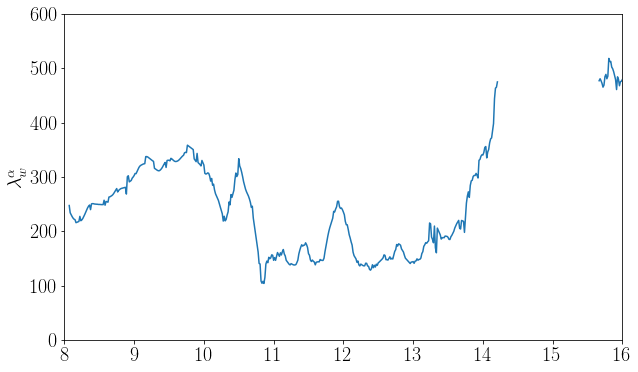

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(Lw.time/3600 + 8, Lw.rolls)
ax.set_ylim(0,600)
ax.set_xlim(8,16)

ax.set_ylabel("$\lambda^{\\alpha}_w$")

Text(0, 0.5, '$\\lambda^{\\beta}_w$')

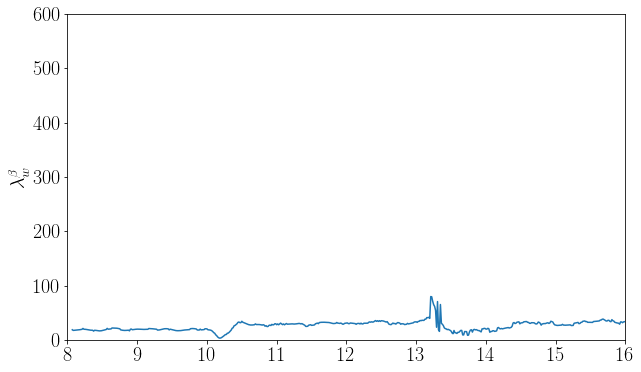

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(Lw.time/3600 + 8, Lw.normal)
ax.set_ylim(0,600)
ax.set_xlim(8,16)

ax.set_ylabel("$\lambda^{\\beta}_w$")

Text(0, 0.5, '$\\lambda^{\\alpha}_w  / \\lambda^{\\beta}_w$')

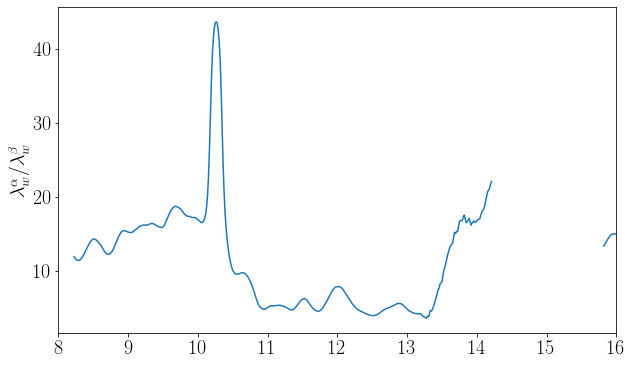

In [37]:
ratio = Lw.rolls / Lw.normal

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(Lw.time/3600 + 8, ratio.rolling(time=12).mean())
# ax.set_ylim(0,600)
ax.set_xlim(8,16)

ax.set_ylabel("$\lambda^{\\alpha}_w  / \lambda^{\\beta}_w$")